In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from scipy import stats
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math
from scipy import stats
from sklearn import preprocessing

from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

# select the style from fivethityeight website
plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['axes.labelsize'] = 14
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

# predefined figsize
figsize=(12,9)

np.random.seed(238746)

plt.style.use('seaborn-dark-palette')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal



#1608 da escludere always
#1065 mape = 9
skus = [2705]#,1065,1206,1058,549,688]
#skus = [2689, 1027, 2696, 2698, 1035,  144, 2704, 1554, 2705, 2707, 2711, 2712, 1051, 2718,
#  546, 1058,  549, 1065,  554,  686,  688, 1206, 2360, 2365, 1472, 1600, 1603, 1732,
#  2249, 1356, 1618, 1365, 1371, 2396, 1633, 2401, 2410, 1516, 2678, 2681, 2682,
# 2683]
SplitTestData = "2018-12"
SplitValData = "2018-09"

import warnings
warnings.filterwarnings("ignore")

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def split_date(X,y,date):
    X_te = X[date:]
    y_te = y[date:]
    X_tr = X[:date]
    y_tr = y[:date]
    return X_tr, X_te, y_tr, y_te 

def plot_results(ytrue, prediction, label):
    df_ytrue = pd.DataFrame(ytrue)
    df_ytrue['predicted'] =  prediction #0.1*pred_test +0.2*pred_test_cat + 0.7*pred_test_xgb
    plt.plot(df_ytrue[label],label='data')
    plt.plot(df_ytrue['predicted'],label='predicted')
    #plt.ylim([200,330])
    plt.xticks(rotation=45)
    mape = mean_absolute_percentage_error(df_ytrue[label],df_ytrue['predicted'])

    plt.title("Forecasting on Test Set MAPE=%.3f"%mape)
    plt.legend();
    plt.show()
    
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=123)
min_max_scaler = preprocessing.MinMaxScaler()

def scale(feature):
    size = len(feature)
    #return min_max_scaler.fit_transform(np.array([feature]).reshape(size, 1)).T[0]
    return quantile_transformer.fit_transform(np.array([feature]).reshape(size, 1)).T[0]
    
def unscale(scaled, original):
    size2 = len(scaled)
    size1 = len(original)
    #return min_max_scaler.fit(np.array([original]).reshape(size1, 1)).inverse_transform(np.array([scaled]).reshape(size2, 1)).T[0]
    return quantile_transformer.fit(np.array([original]).reshape(size1, 1)).inverse_transform(np.array([scaled]).reshape(size2, 1)).T[0]

In [2]:
def create_features(df, label=None):
    
    
    #df['log_target'] = np.log(df['target']) 
    #df["logt-1"] = np.log(df["sales w-1"])
    df2 = pd.DataFrame(columns= df.columns)

    for sku in df['sku'].unique():
        sales_sku = df.loc[df['sku'] == sku]
        sales_sku["log_price"] = scale(sales_sku["price"])

    #sales_sku = sales.set_index(['Week'])
        sales_sku['diff1'] = -(scale(sales_sku['sales w-1']) - scale(sales_sku['sales w-1'].shift(1)))
        sales_sku['diff2'] = -(scale(sales_sku['sales w-1']) - scale(sales_sku['sales w-1'].shift(2)))
        sales_sku['diff3'] = -(scale(sales_sku['sales w-1']) - scale(sales_sku['sales w-1'].shift(3)))
        sales_sku['pdiff1'] = -(sales_sku['sales w-1'] - sales_sku['sales w-1'].shift(1))/sales_sku['sales w-1']
        sales_sku['price_diff1'] = -(sales_sku['log_price'] - sales_sku['log_price'].shift(1))

        
        df2 = pd.concat((df2, sales_sku), axis = 0)

    df = df2
 
    df['date'] = df.index
    #df["log_price"] = scale(df["price"])
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear/7
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df["promo"] = scale(df["volume_on_promo w-1"])
    df['log_sales'] = scale(df['sales w-1'])
    
    df["rolling2"] = df["sales w-1"].rolling(3).mean()

    df["rolling3"] = df["sales w-1"].rolling(2).mean()
    df["sku"] = df["sku"].apply(lambda x: int(x))
    
    df = df.dropna()

    df = df.set_index("date")

    X = df[['quarter','month','year',"sales w-1",'price_diff1',
           'dayofyear','dayofmonth','weekofyear',"log_sales",
            'promo','diff1','diff2','pdiff1','log_price',"rolling2","rolling3","sku"]]
    
    if label:
        y = df[label]
        return X, y
    return X

In [3]:
# Read train and test files
train_df = pd.read_csv('../data/raw/train.csv')
#test_df = pd.read_csv('../data/raw/x_test.csv')

train_df = train_df.drop(["target"],axis = 1)

#all_df = pd.concat([train_df,test_df])
all_df = train_df

all_df = all_df.rename({"Unnamed: 0":"date"}, axis=1).dropna()
#all_df = all_df.loc[all_df["scope"] == 1]
all_df = all_df.drop(["scope"],axis = 1)

all_df.date = all_df.date.apply(lambda x:datetime.strptime(x[3:], '%d %B %Y'))
all_df.head()

,date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1
1,2016-12-17,2689,SINGLE,395.41,BRAND1,1.15,1.0,17.676112,24175.0
2,2016-12-24,2689,SINGLE,395.41,BRAND1,1.16,1.0,24.482803,23521.0
3,2016-12-31,2689,SINGLE,395.41,BRAND1,1.16,0.0,19.410646,22075.0
4,2017-01-07,2689,SINGLE,395.41,BRAND1,1.16,0.0,29.812030,16492.0
5,2017-01-14,2689,SINGLE,395.41,BRAND1,1.16,0.0,29.058565,25971.0


In [4]:
#crea la colonna target
all_df = all_df.set_index("date")

t2 = pd.DataFrame(columns= all_df.columns)

originals = pd.DataFrame(columns = ["target","sku"])

for sku in all_df['sku'].unique():
    
    sales_sku = all_df.loc[all_df['sku'] == sku]
    #sales_sku = sales.set_index(['Week'])
    if sku in skus:
        new = pd.DataFrame({"target":sales_sku["sales w-1"].shift(-1)[:-1],"sku":sales_sku["sku"][:-1]},index = sales_sku.index[:-1])
        originals = pd.concat([originals,new])
    sales_sku['target'] = np.append(scale(sales_sku["sales w-1"].shift(-1)[:-1]),0.0)
    sales_sku = sales_sku[:-1]
    t2 = pd.concat((t2, sales_sku), axis = 0)

#t2 = t2.loc[t2["sku"] == 554]
t2 = t2.loc[np.isin(t2["sku"],skus)]#,554,1206,1058,549,688])]
t2.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131 entries, 2016-12-17 to 2019-06-15
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sku                  131 non-null    object 
 1   pack                 131 non-null    object 
 2   size (GM)            131 non-null    float64
 3   brand                131 non-null    object 
 4   price                131 non-null    float64
 5   POS_exposed w-1      131 non-null    float64
 6   volume_on_promo w-1  131 non-null    float64
 7   sales w-1            131 non-null    float64
 8   target               131 non-null    float64
dtypes: float64(6), object(3)
memory usage: 10.2+ KB


In [5]:
t2["target"]

2016-12-17   -0.502402
2016-12-24   -0.569185
2016-12-31   -2.160044
2017-01-07    0.686643
2017-01-14    1.869607
                ...   
2019-05-18   -0.459112
2019-05-25   -0.416666
2019-06-01   -0.615141
2019-06-08   -0.313572
2019-06-15   -0.354350
Name: target, Length: 131, dtype: float64

In [6]:
#DIVISIONE TRAIN VALIDATION TEST

X_train, y_train = create_features(t2, label='target')

X_train, X_test,y_train ,y_test = split_date(X_train,y_train, SplitTestData)

y_train = y_train[pd.notnull(X_train).all(1)]
X_train = X_train.dropna()

dev_X, val_X, dev_y, val_y = split_date(X_train, y_train, SplitValData)

print(len(val_X))
print(len(val_y))
print(len(dev_X))
print(len(dev_y))
print(len(X_test))
print(y_test)

18
18
91
91
29
date
2018-12-01   -1.541986
2018-12-08   -1.683348
2018-12-15   -1.993984
2018-12-22   -1.869607
2018-12-29   -5.199338
2019-01-05   -1.768825
2019-01-12   -0.662435
2019-01-19   -0.711260
2019-01-26   -1.238894
2019-02-02   -1.281552
2019-02-09   -0.897915
2019-02-16   -1.159742
2019-02-23   -1.122762
2019-03-02   -0.686643
2019-03-09   -0.736316
2019-03-16   -0.841621
2019-03-23   -0.988155
2019-03-30   -0.869424
2019-04-06   -1.198380
2019-04-13   -1.426077
2019-04-20   -0.957209
2019-04-27   -1.608653
2019-05-04   -0.787876
2019-05-11   -1.326678
2019-05-18   -0.459112
2019-05-25   -0.416666
2019-06-01   -0.615141
2019-06-08   -0.313572
2019-06-15   -0.354350
Name: target, dtype: float64


In [7]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "mape",
        "num_leaves" : 60,
        "learning_rate" : 0.08,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 100, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=50, 
                      verbose_eval=150, 
                      evals_result=evals_result,
                     categorical_feature = ["sku"])
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [8]:
# LGB
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, X_test)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's mape: 0.222472	valid_1's mape: 0.394852
LightGBM Training Completed...


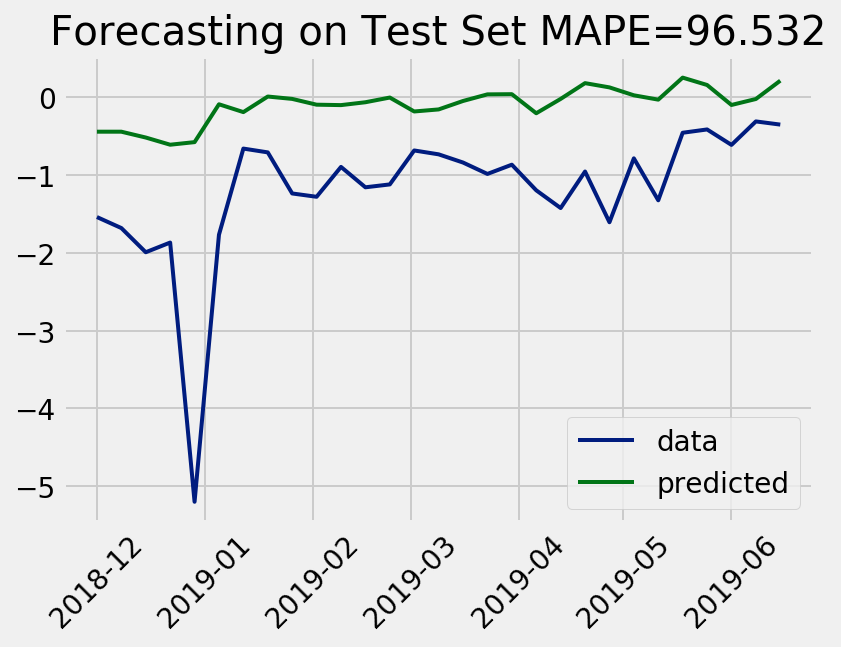

In [9]:
plot_results(y_test, pred_test, "target")  


In [10]:
# feature importance
print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
featureimp[:50]

Features Importance...


,feature,split,gain
3,sales_w-1,26,44.470289
15,rolling3,11,11.444088
8,log_sales,11,9.439488
5,dayofyear,43,8.335857
2,year,23,6.010399
6,dayofmonth,34,5.241012
7,weekofyear,28,3.926843
14,rolling2,21,2.857492
11,diff2,21,1.979753
0,quarter,11,1.675888


In [11]:
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params = {'objective': 'reg:squarederror', 
          'eval_metric': 'rmsle',
          'eta': 0.1,
          'max_depth': 500, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.01,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=True, early_stopping_rounds = 100)
    
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit)
    
    return xgb_pred_y, model_xgb

In [12]:
# XGB
xreg = xgb.XGBRegressor(n_estimators=1000)
xreg.fit(dev_X, dev_y,
        eval_set=[(dev_X, dev_y), (val_X, val_y)],
        early_stopping_rounds=100,
       verbose=False)
pred_test_xgb = xreg.predict(X_test)
#pred_test_xgb, model_xgb = run_xgb(dev_X, dev_y, val_X, val_y, X_test)
print("XGB Training Completed...")

XGB Training Completed...


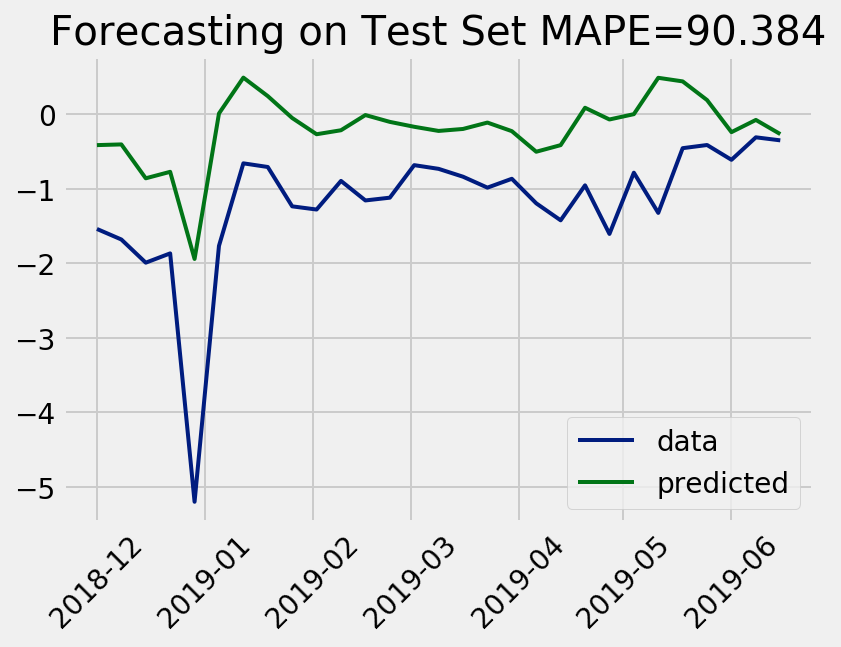

In [13]:
plot_results(y_test, pred_test_xgb, "target")  


In [14]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.5,
                             depth=10,
                             eval_metric='MAPE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

In [15]:
cb_model.fit(dev_X, dev_y,
             eval_set=(val_X, val_y),
             use_best_model=True,
             verbose=50)

0:	learn: 0.3733424	test: 1.1241629	best: 1.1241629 (0)	total: 57.6ms	remaining: 28.7s
50:	learn: 0.0014674	test: 0.6173525	best: 0.6173525 (50)	total: 604ms	remaining: 5.32s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.617179729
bestIteration = 61

Shrink model to first 62 iterations.


In [16]:
pred_test_cat = cb_model.predict(X_test)

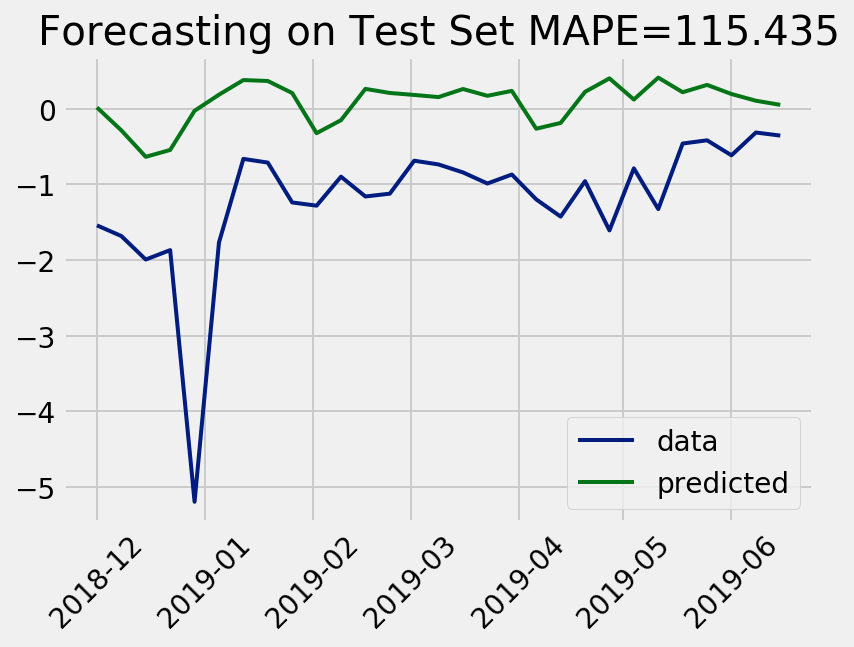

In [17]:
plot_results(y_test, pred_test_cat, "target")  


In [18]:
df_result_combined = pd.DataFrame(y_test)
df_result_combined.head()

,target
date,
2018-12-01,-1.541986
2018-12-08,-1.683348
2018-12-15,-1.993984
2018-12-22,-1.869607
2018-12-29,-5.199338


In [19]:
forest = RandomForestRegressor(n_estimators=1000, random_state=123)
forest.fit(X_train, y_train)

forest_yt = forest.predict(X_train)
forest_yp = forest.predict(X_test)

print('RMSE on Test %.3f'%math.sqrt(mean_squared_error(y_test,forest_yp)))
mape = mean_absolute_percentage_error(y_test,forest_yp)
print('MAPE on Test %.3f'%mape)


RMSE on Test 0.587
MAPE on Test 39.132


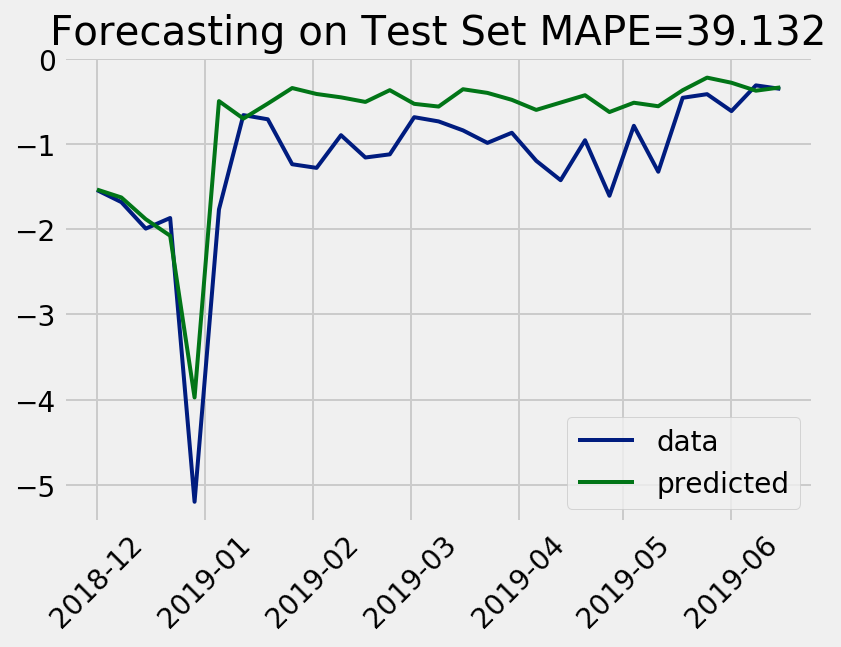

In [20]:
plot_results(y_test, forest_yp, "target")

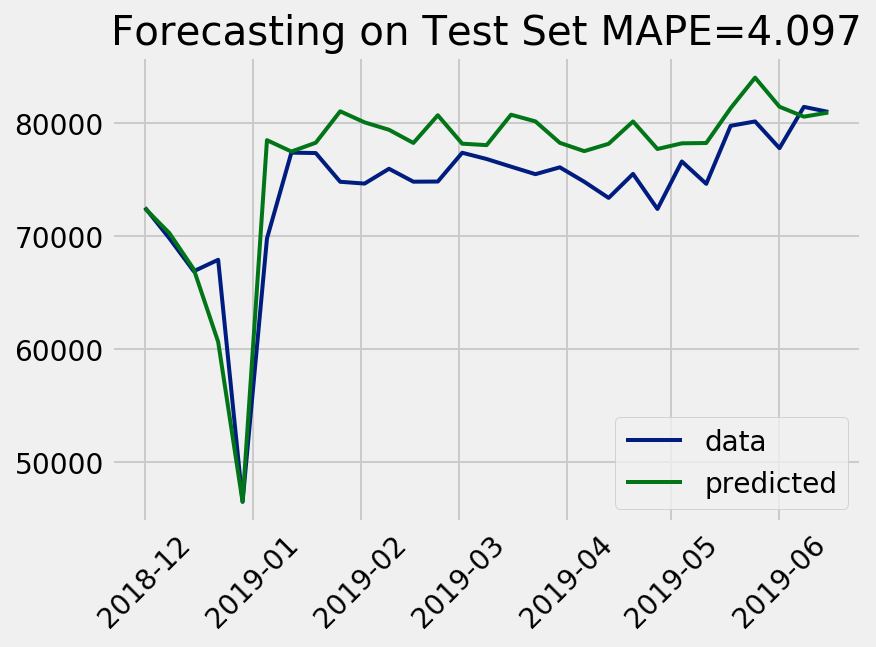

In [23]:
prediction = 0.1*pred_test_xgb +1.0*forest_yp + 0.0* pred_test#+ 1*pred_test_cat
#prediction = 0.*pred_test_xgb + 0.9*forest_yp

results = pd.DataFrame(columns = ["sku","target","prediction"], index = originals[SplitTestData:].index)


for sku in originals["sku"].unique():
    partial = originals.loc[originals["sku"] == sku][SplitTestData:]
    pred = unscale(prediction[np.where(originals["sku"][SplitTestData:] == sku)],originals.loc[originals["sku"] == sku]["target"])
    
    results = pd.concat([results, pd.DataFrame({
        "sku" : partial["sku"],
        "target" : partial["target"],
        "prediction" : pred
    })])
results = results.dropna()

plot_results(originals[SplitTestData:], results["prediction"], "target")  


In [24]:
forest.feature_importances_
X_train.columns

array([0.00385998, 0.02190815, 0.00748149, 0.18260574, 0.00127789,
       0.10879775, 0.02197737, 0.11717427, 0.17937136, 0.02505355,
       0.03550684, 0.01801777, 0.03140215, 0.00200593, 0.06850676,
       0.17505298, 0.        ])

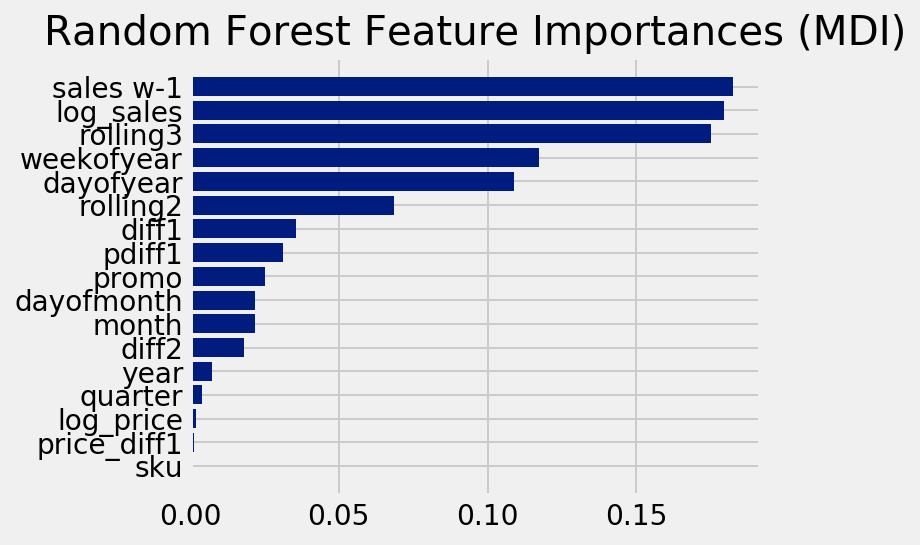

In [27]:
tree_feature_importances = forest.feature_importances_
sorted_idx = tree_feature_importances.argsort()
feature_names = X_train.columns
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()